# Hierarchical Clustering of Questionair Responses

* [Data preparation](#prep)
* [Clustering survey responces](#clust)
* [Personality trait](#pers)
* [Stats](#stats)


In [2]:
import numpy as np 
import pandas as pd
import xgboost
import shap
import matplotlib.pyplot as plt
from textwrap import wrap
from matplotlib import offsetbox
from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import classification_report

## Data preparation <a class="anchor" id="prep"></a>

In [3]:
df = pd.read_csv("CAPABLE_Questionair_Behaviourl_Models.csv")

### Removing demographic information 

In [4]:
df1 = df.drop(columns=['Unnamed: 0', 'Timestamp',
       'Do you agree that your answers will be used for research purposes? ',
       'You identify yourself as:', 'Age', 'Nationality',
       'Have you been diagnosed with cancer? ']) 

removing open question and number of responces that are not rating 1-5

In [5]:
df1 = df1.drop(columns=['What motivates you the most to maintain healthy habits?',
       'When do you feel like you can/want to perform an activity that is beneficial to your health? ',
       'How do you remind yourself to perform activities aligned with your goals? ',
                       'How many daily reminders for health-related activities would you be willing to receive? ', 
                       'Select a simple activity that you would be happy to perform to improve your wellbeing.  Consider this activity when answering later questions in this survey. '])

removing personality questions

In [6]:
personality_qestions = ['I see myself as someone who is reserved',
                        'I see myself as someone who is generally trusting',
       'I see myself as someone who tends to be lazy',
       'I see myself as someone who is relaxed, handles stress well',
       'I see myself as someone who has few artistic interests',
       'I see myself as someone who is outgoing, sociable',
       'I see myself as someone who tends to find fault with others',
       'I see myself as someone who does a thorough job',
       'I see myself as someone who gets nervous easily',
       'I see myself as someone who has an active imagination'
     ]

In [7]:
df1 = df1.drop(columns=personality_qestions)

In [8]:
dfs = df1.fillna(3) # neutral

In [9]:
dfs.head()

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort),My family members motivate me to look after my health,When I am in a good mood I am motivated to perform activities that benefit my health,When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule,"Before the visit to my doctor, I tend to be more compliant with my health recommendations","If I see that my peers perform health-related activities better than me, I get discouraged",If I see that I perform health-related activities better than my peers I feel motivated,I am keen to perform a simple activity for a longer time when I compete with others,I am keen to perform a simple activity for a longer time when I want to break my own record,...,I am more likely to perform suggested health-related activity when I am not focused on any other tasks,When I am stressed I am unlikely to respond to any reminders for health-related activities,When I am stressed I find it helpful to perform a relaxing/calming down activity,When I am tired I am unlikely to respond to reminders for health-related activities,I am likely to respond to reminders for health-related activities when I am bored,I am more likely to respond to reminders for health-related activities when I am relaxed than when I am stressed,I am likely to respond to reminders for health-related activities when I am relaxed,"I am more likely to respond to the reminders for health-related activities when I am at home than elsewhere (park, shop, etc.)",I would respond to reminders for health-related activities while I am walking.,I would respond to reminders for health-related activities while I am sitting or standing.
0,4,4.0,4.0,5.0,3.0,2,3,3,3.0,4,...,5.0,2.0,4.0,2.0,5.0,3.0,4.0,5.0,2.0,4.0
1,3,5.0,2.0,4.0,2.0,2,2,3,3.0,4,...,5.0,4.0,3.0,5.0,1.0,5.0,5.0,2.0,2.0,5.0
2,3,5.0,3.0,5.0,5.0,3,3,4,4.0,4,...,4.0,4.0,4.0,4.0,2.0,4.0,3.0,4.0,4.0,4.0
3,4,5.0,5.0,4.0,2.0,3,2,4,3.0,4,...,4.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0
4,5,5.0,4.0,5.0,4.0,4,3,4,5.0,5,...,5.0,5.0,5.0,3.0,4.0,2.0,4.0,5.0,2.0,4.0


## Clustering based on the survey responces <a class="anchor" id="clust"></a>

In [10]:
def get_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dic = dendrogram(linkage_matrix, **kwargs)
    return dic

In [11]:
model3 = AgglomerativeClustering(distance_threshold=0,n_clusters=None, linkage='ward')
model3 = model3.fit(dfs)

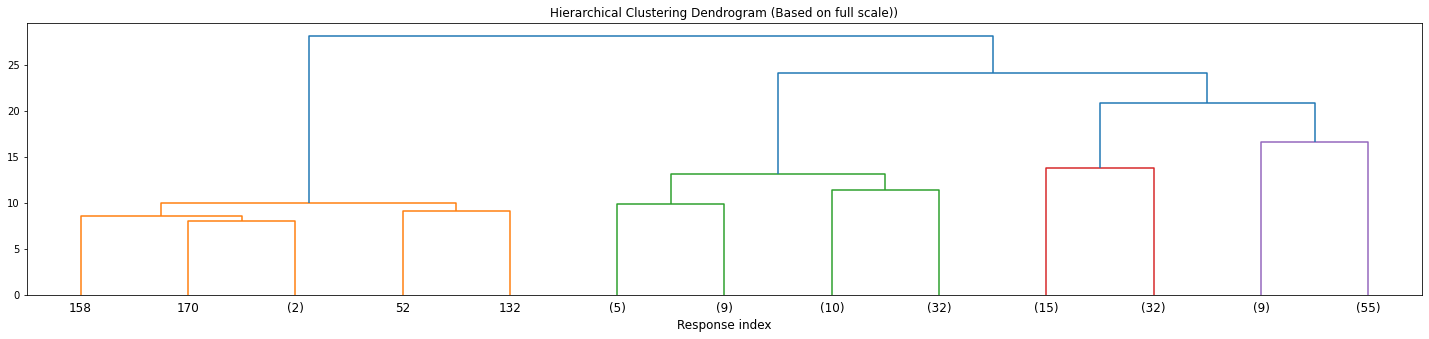

In [12]:
fig = plt.figure(figsize = (25,5))
plt.title('Hierarchical Clustering Dendrogram (Based on full scale))')
# plot the top three levels of the dendrogram
get_dendrogram(model3, truncate_mode='level', p=3)
plt.xlabel("Response index", fontsize= 12 )
plt.xticks(fontsize= 12 )
plt.show()

### Check Cluster stability

Random drop of 10 responces

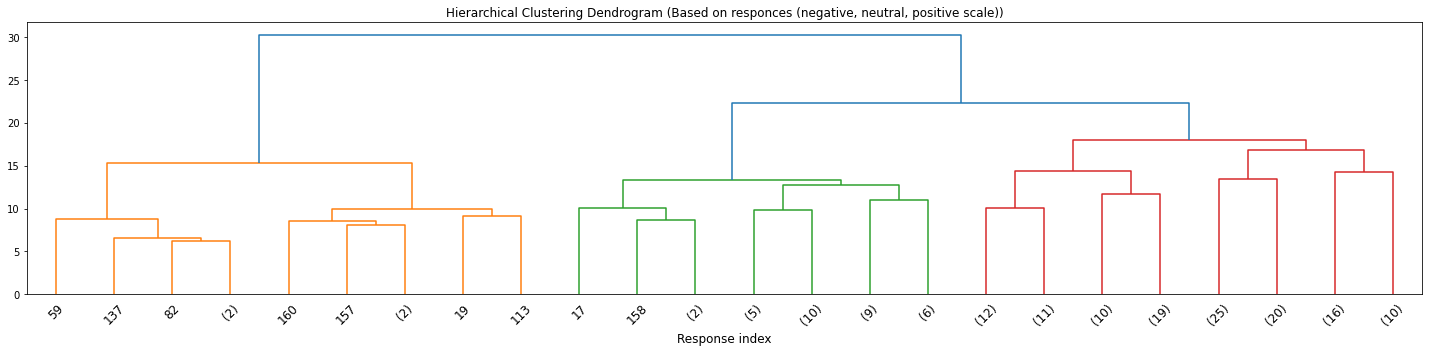

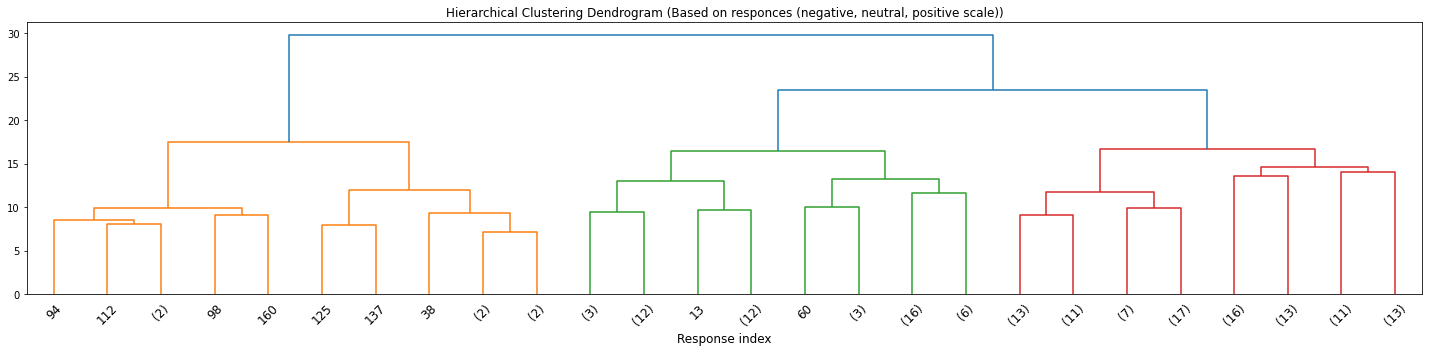

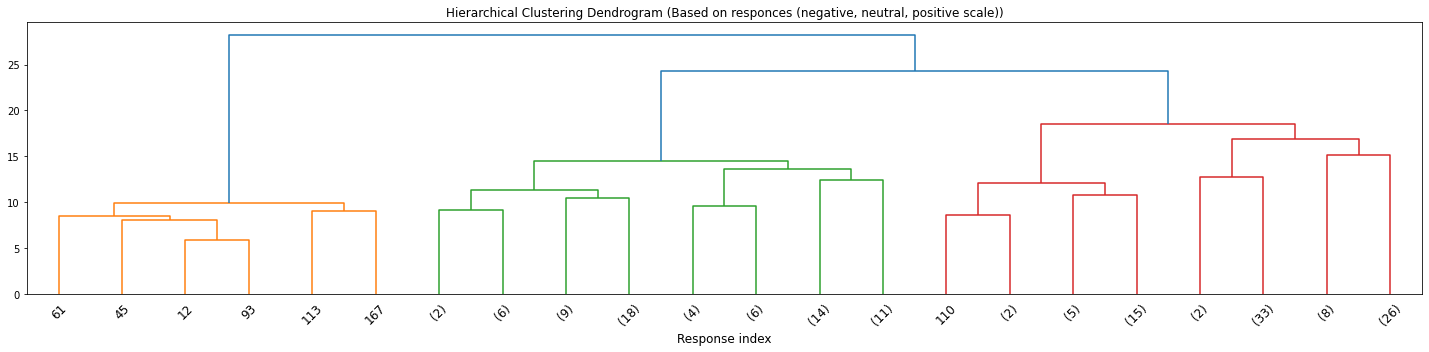

In [13]:
remove_n = 5
keep_samples = len(dfs) - remove_n
for i in range(3):
    train = np.random.choice(dfs.index, keep_samples, replace=False)
    currnet_subset =  dfs.iloc[train]
    model = AgglomerativeClustering(distance_threshold=0.5,n_clusters=None)
    model = model.fit(currnet_subset)
    fig = plt.figure(figsize = (25,5))
    plt.title('Hierarchical Clustering Dendrogram (Based on responces (negative, neutral, positive scale))')
    get_dendrogram(model, truncate_mode='level', p=4)
    plt.xlabel("Response index", fontsize= 12 )
    plt.xticks(fontsize= 12 )
    plt.show()

In [14]:
model3 = AgglomerativeClustering(distance_threshold=None,n_clusters=4)
model3 = model3.fit(dfs)
clust1 = pd.DataFrame(index =dfs.index,data=model3.labels_, columns=['cluster'])

In [15]:
mCluster = pd.merge(dfs,clust1, how='inner', left_index=True, right_index=True)

In [16]:
mCluster.head()

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort),My family members motivate me to look after my health,When I am in a good mood I am motivated to perform activities that benefit my health,When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule,"Before the visit to my doctor, I tend to be more compliant with my health recommendations","If I see that my peers perform health-related activities better than me, I get discouraged",If I see that I perform health-related activities better than my peers I feel motivated,I am keen to perform a simple activity for a longer time when I compete with others,I am keen to perform a simple activity for a longer time when I want to break my own record,...,When I am stressed I am unlikely to respond to any reminders for health-related activities,When I am stressed I find it helpful to perform a relaxing/calming down activity,When I am tired I am unlikely to respond to reminders for health-related activities,I am likely to respond to reminders for health-related activities when I am bored,I am more likely to respond to reminders for health-related activities when I am relaxed than when I am stressed,I am likely to respond to reminders for health-related activities when I am relaxed,"I am more likely to respond to the reminders for health-related activities when I am at home than elsewhere (park, shop, etc.)",I would respond to reminders for health-related activities while I am walking.,I would respond to reminders for health-related activities while I am sitting or standing.,cluster
0,4,4.0,4.0,5.0,3.0,2,3,3,3.0,4,...,2.0,4.0,2.0,5.0,3.0,4.0,5.0,2.0,4.0,1
1,3,5.0,2.0,4.0,2.0,2,2,3,3.0,4,...,4.0,3.0,5.0,1.0,5.0,5.0,2.0,2.0,5.0,0
2,3,5.0,3.0,5.0,5.0,3,3,4,4.0,4,...,4.0,4.0,4.0,2.0,4.0,3.0,4.0,4.0,4.0,2
3,4,5.0,5.0,4.0,2.0,3,2,4,3.0,4,...,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,2
4,5,5.0,4.0,5.0,4.0,4,3,4,5.0,5,...,5.0,5.0,3.0,4.0,2.0,4.0,5.0,2.0,4.0,2


### Responce histogram by cluster

I feel motivated to perform activities that I perceive having benefit to my health and well-being


To output multiple subplots, the figure containing the passed axes is being cleared


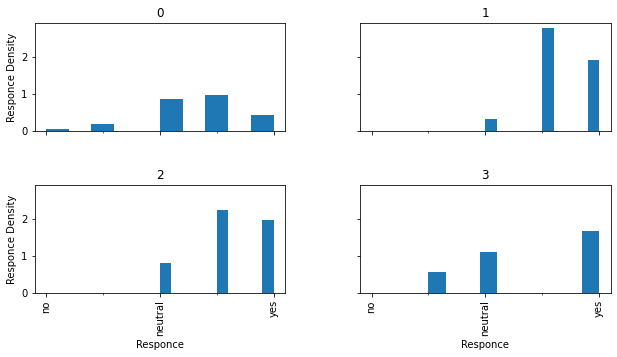

When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort) 


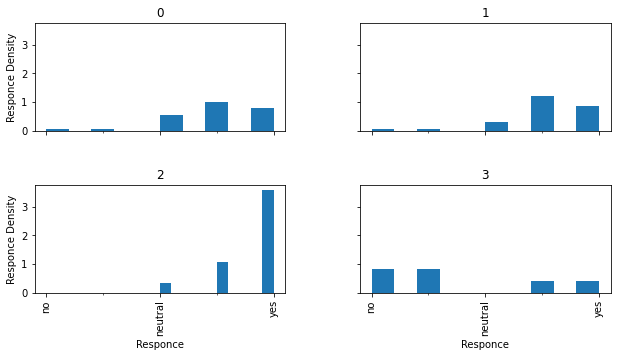

My family members motivate me to look after my health


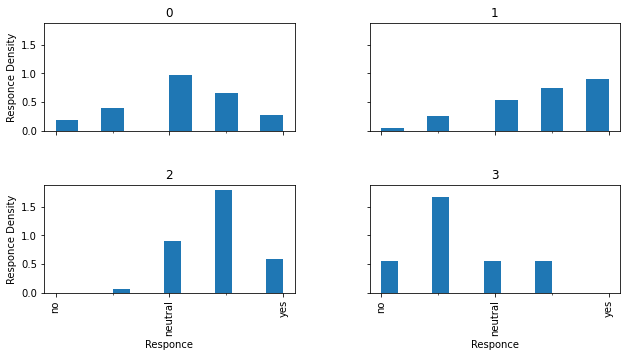

When I am in a good mood I am  motivated to perform activities that benefit my health


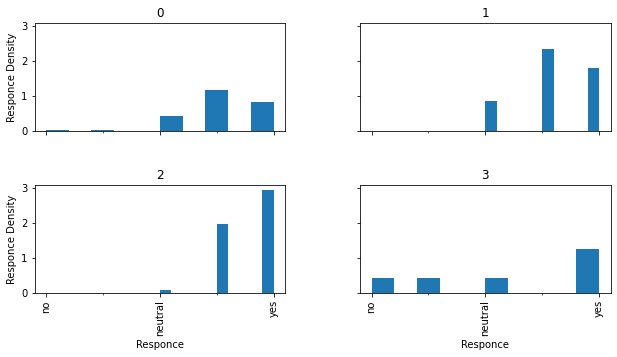

When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule


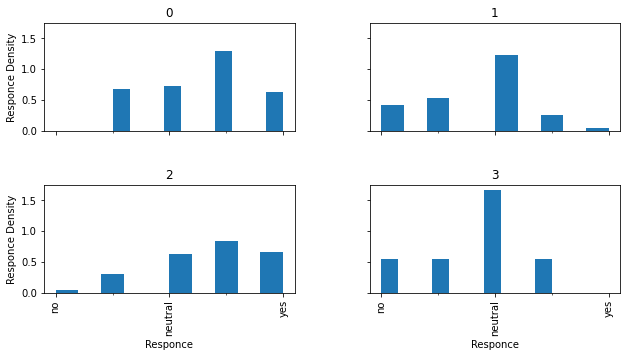

Before the visit to my doctor, I tend to be more compliant with my health recommendations


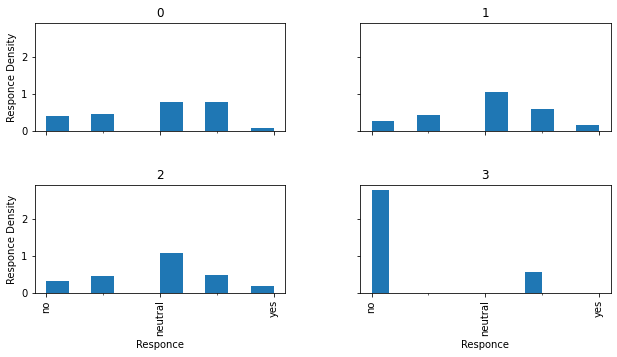

If I see that my peers perform health-related activities better than me,  I get discouraged 


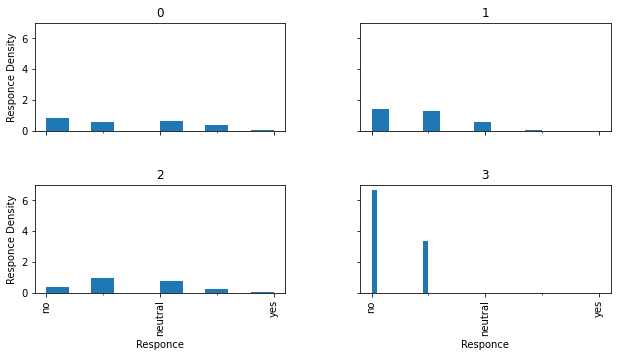

If I see that I perform health-related activities better than my peers I feel motivated


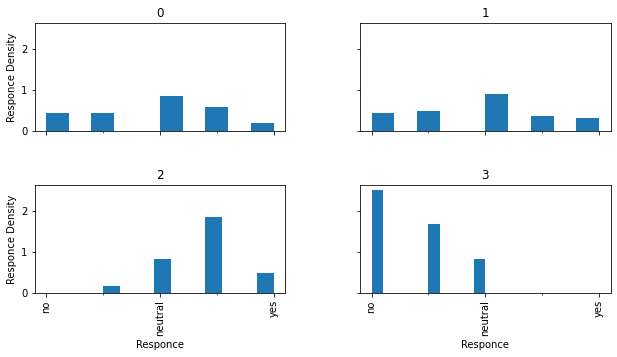

I am keen to perform a simple activity for a longer time when I compete with others


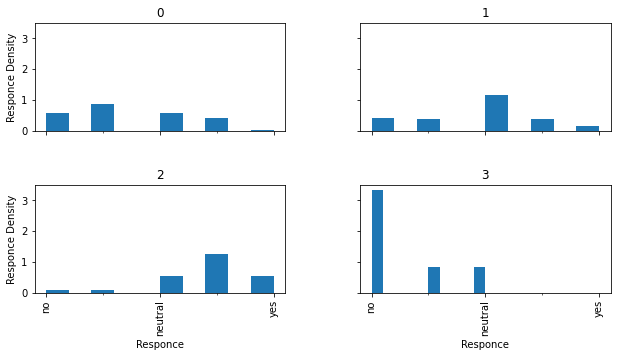

I am keen to perform a simple activity for a longer time when I want to break my own record


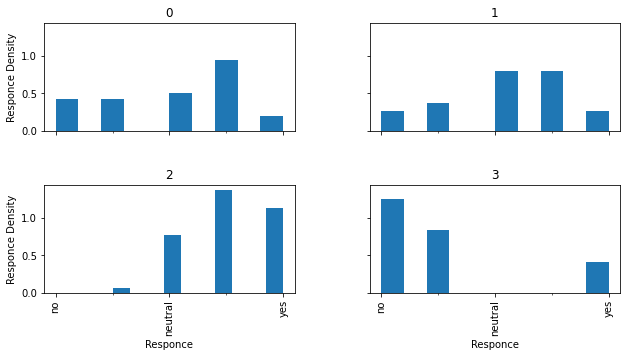

I feel stressed when I do not complete my daily health-related activities


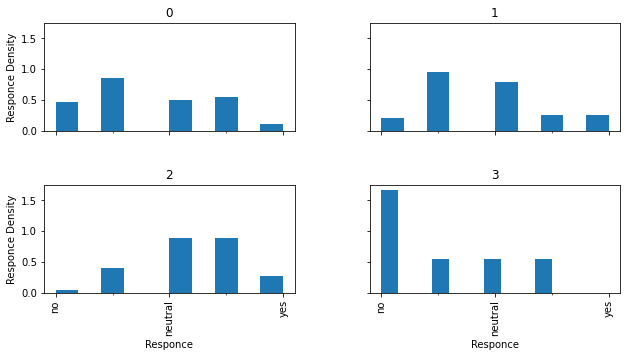

If I do not like recommended health-related activity, I would not perform it


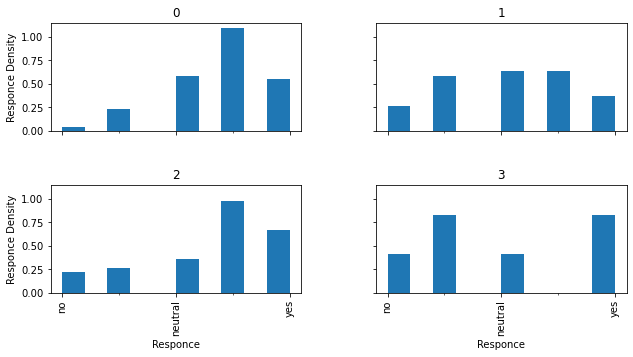

I am likely to perform a harder health-related activity when I am well rested


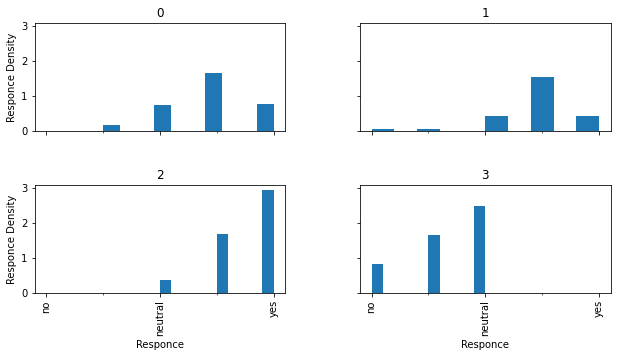

I am confident to perform a suggested health-related activity if I performed it already multiple times before


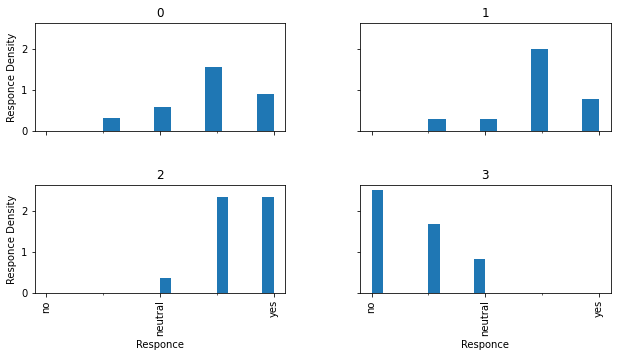

I would not perform a simple health-related activity (such as deep breathing) for longer than the recommended minimum, as I would get bored


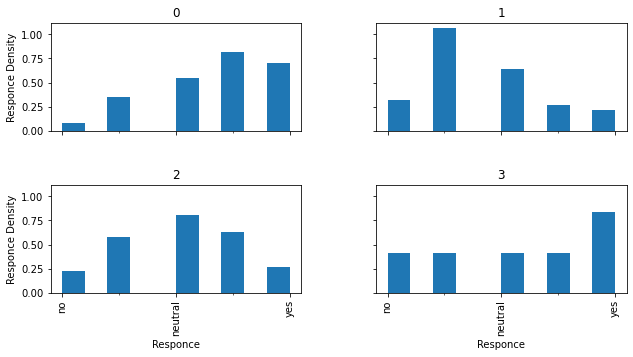

I am keen to perform a simple health-related activity for longer than the recommended minimum time, when I enjoy it 


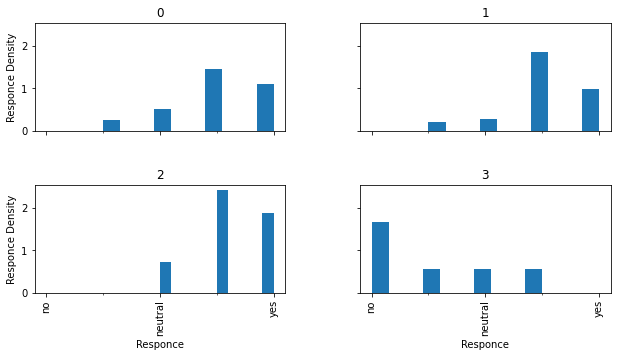

I am more likely to perform suggested health-related activity  when I am not focused on any other tasks


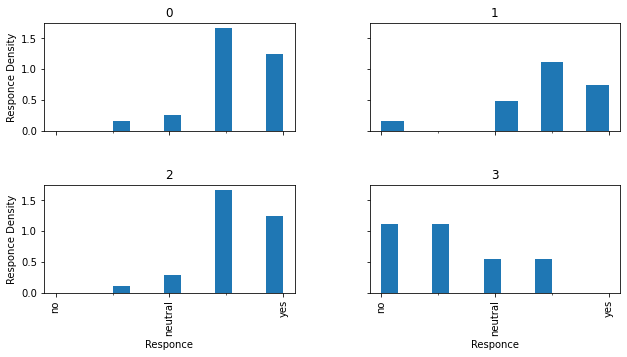

When I am stressed I am unlikely to respond to any reminders for health-related activities


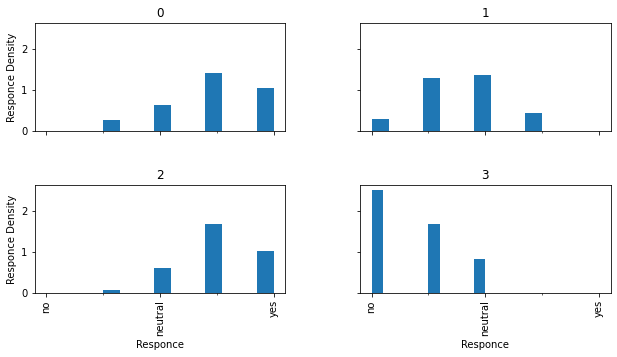

When I am stressed I find it helpful to perform a relaxing/calming down activity


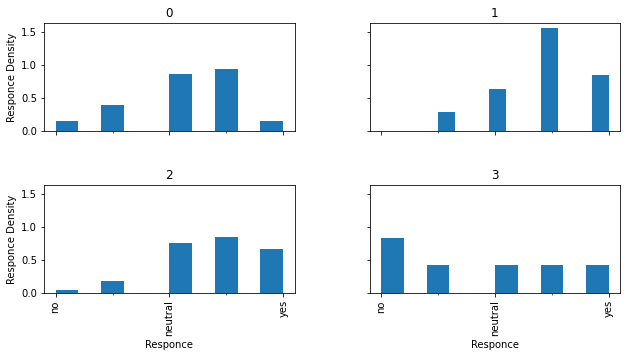

When I am tired  I am unlikely to respond to reminders for health-related activities


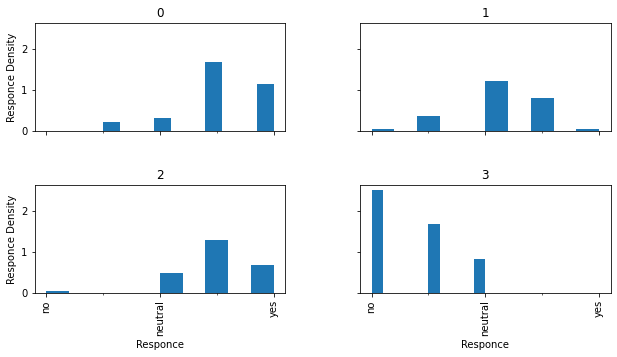

I am likely to respond to reminders for health-related activities when I am bored


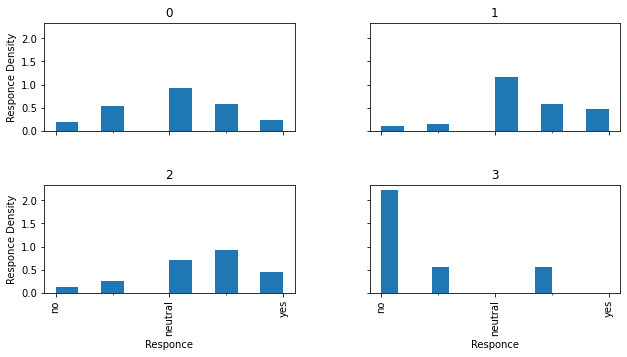

I am more likely to respond to reminders for health-related activities when I am relaxed than when I am stressed


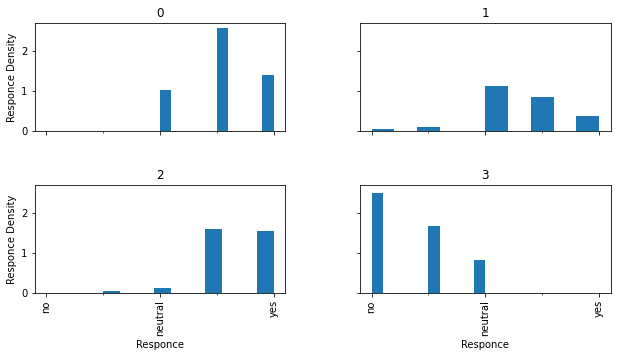

I am likely to respond to reminders for health-related activities when I am relaxed


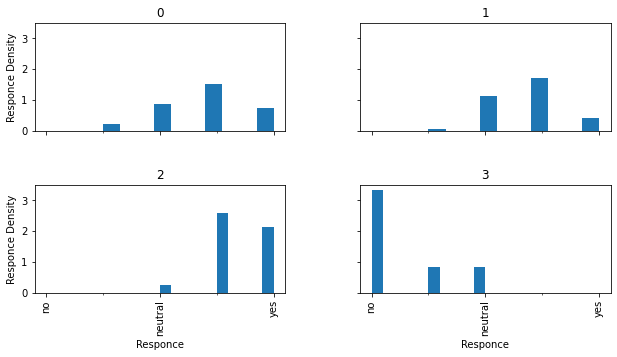

I am more likely to respond to the reminders for health-related activities when I am at home than elsewhere (park, shop, etc.)


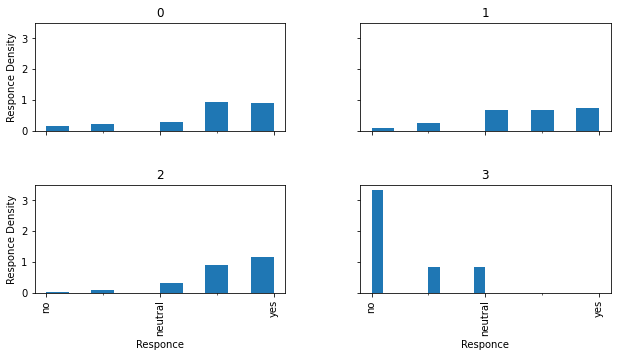

I would respond to reminders for health-related activities while I am walking. 


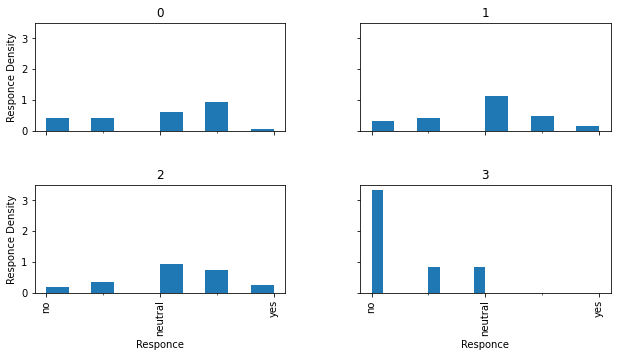

I would respond to reminders for health-related activities while I am sitting or standing. 


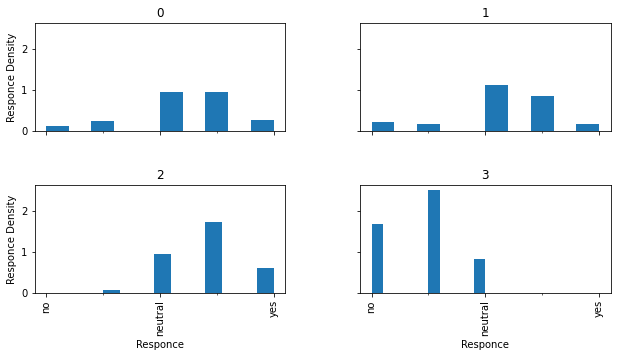

In [17]:
for q in dfs.columns:
    fig = plt.figure(figsize = (10,5))
    ax = fig.gca()
    ticks = [1,3,5]
    print(q)
    axarr = mCluster[q].hist(by=mCluster['cluster'], ax = ax, sharex=True, sharey=True, align='mid', density=True)
    for ax in axarr.flatten():
        ax.set_xlabel("Responce")
        ax.set_xticks(ticks, minor=False)
        ax.set_xticklabels(  ['no', 'neutral', 'yes'])
        ax.set_ylabel("Responce Density")
    
    plt.show()

### Questions that help us discriminate betweem clusters

In [18]:
forest = RandomForestClassifier(random_state=6,   min_samples_leaf=15 ,class_weight="balanced")

X_train,X_test,Y_train,Y_test = train_test_split(dfs, clust1, test_size=0.25, random_state=6)
forest.fit(X_train, Y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(class_weight='balanced', min_samples_leaf=15,
                       random_state=6)

In [19]:
print("RF train accuracy: %0.3f" % forest.score(X_train, Y_train))
print("RF test accuracy: %0.3f" % forest.score(X_test, Y_test))

RF train accuracy: 0.791
RF test accuracy: 0.727


In [20]:
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)

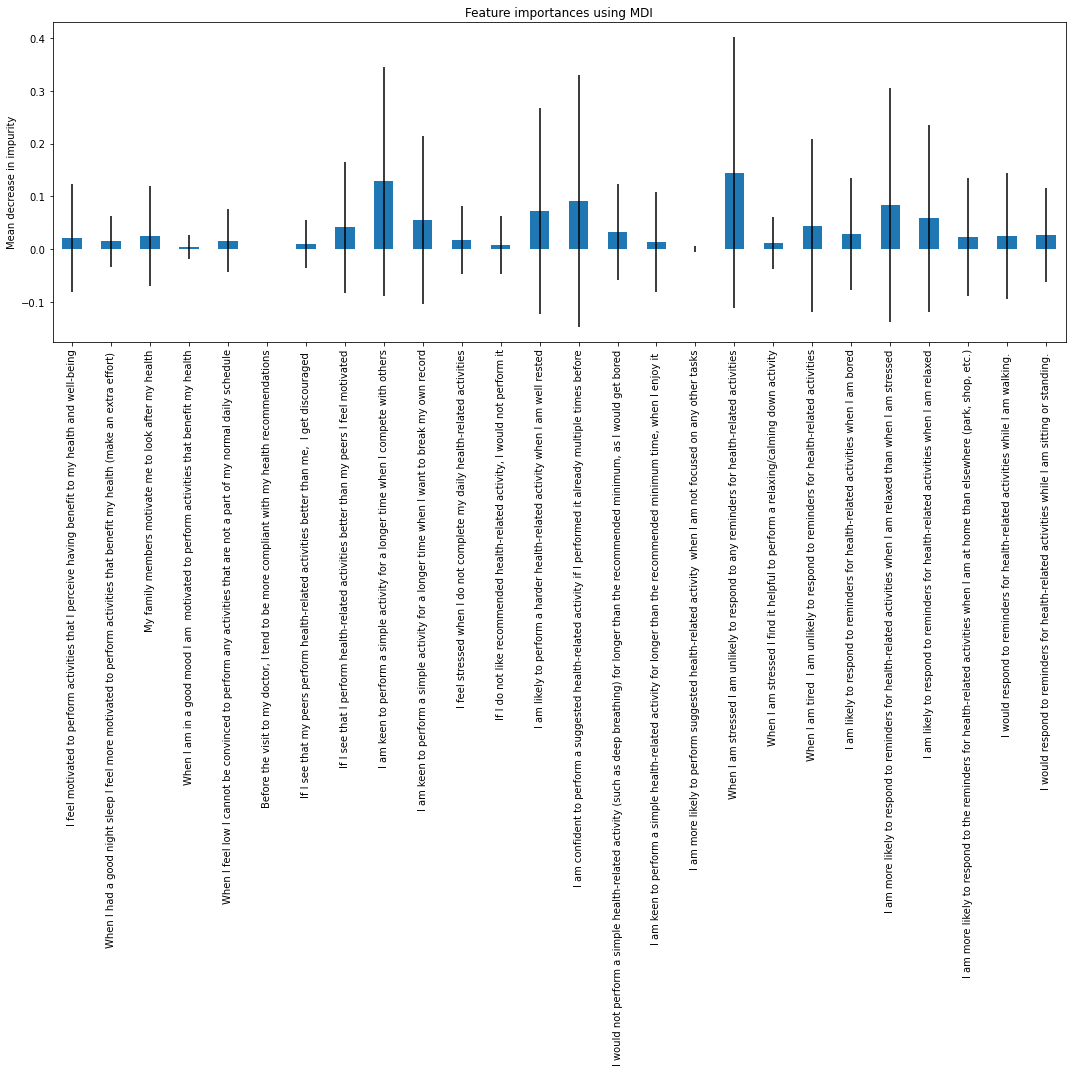

In [21]:

forest_importances = pd.Series(importances, index=dfs.columns)

fig, ax = plt.subplots(figsize = (15,15))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [22]:
sorted_idx = forest_importances.argsort()

In [23]:
top10 = forest_importances[sorted_idx][-9:]

In [24]:
top10

If I see that I perform health-related activities better than my peers I feel motivated                             0.041699
When I am tired  I am unlikely to respond to reminders for health-related activities                                0.044261
I am keen to perform a simple activity for a longer time when I want to break my own record                         0.055411
I am likely to respond to reminders for health-related activities when I am relaxed                                 0.058405
I am likely to perform a harder health-related activity when I am well rested                                       0.072202
I am more likely to respond to reminders for health-related activities when I am relaxed than when I am stressed    0.083067
I am confident to perform a suggested health-related activity if I performed it already multiple times before       0.091608
I am keen to perform a simple activity for a longer time when I compete with others                                 0.129063


In [25]:
perm_importance = permutation_importance(forest, X_test, Y_test,n_repeats=30, random_state=6)

Text(0.5, 0, 'Permutation Importance')

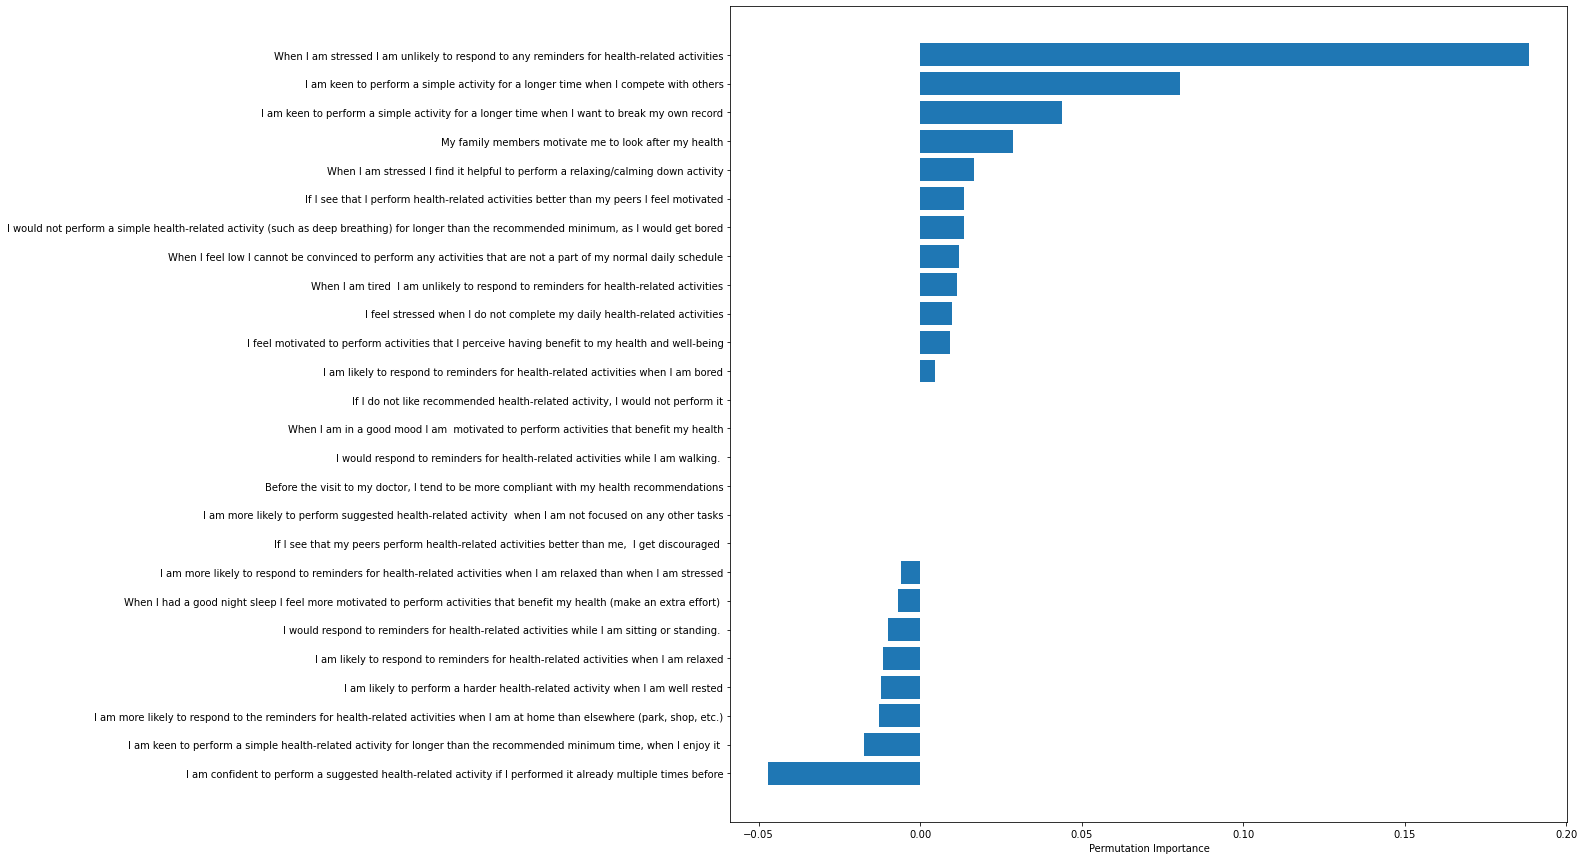

In [26]:
fig, ax = plt.subplots(figsize = (15,15))
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(dfs.columns.values[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


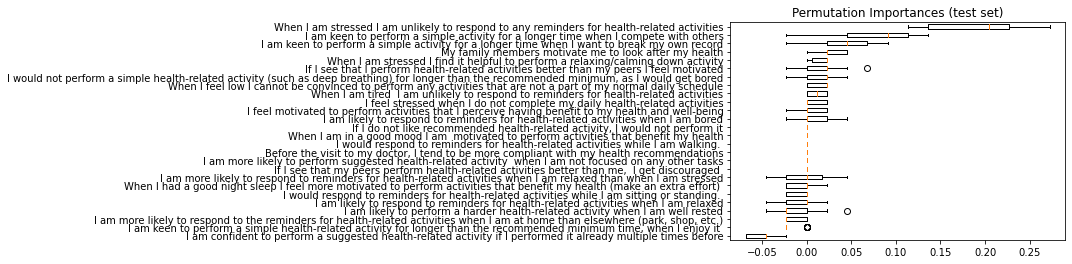

In [27]:
fig, ax = plt.subplots()
ax.boxplot(perm_importance.importances[sorted_idx].T,
           vert=False, labels=dfs.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [28]:
top_10again = dfs.columns.values[sorted_idx][-9:]

In [29]:
top_10again

array(['When I am tired  I am unlikely to respond to reminders for health-related activities',
       'When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule',
       'I would not perform a simple health-related activity (such as deep breathing) for longer than the recommended minimum, as I would get bored',
       'If I see that I perform health-related activities better than my peers I feel motivated',
       'When I am stressed I find it helpful to perform a relaxing/calming down activity',
       'My family members motivate me to look after my health',
       'I am keen to perform a simple activity for a longer time when I want to break my own record',
       'I am keen to perform a simple activity for a longer time when I compete with others',
       'When I am stressed I am unlikely to respond to any reminders for health-related activities'],
      dtype=object)

In [30]:
top_questions =list(set.intersection(set(list(top10.index)), set(list(top_10again))))

In [31]:
len(top_questions)

5

In [32]:
top_questions

['If I see that I perform health-related activities better than my peers I feel motivated',
 'When I am stressed I am unlikely to respond to any reminders for health-related activities',
 'I am keen to perform a simple activity for a longer time when I want to break my own record',
 'I am keen to perform a simple activity for a longer time when I compete with others',
 'When I am tired  I am unlikely to respond to reminders for health-related activities']

### Dropping indisciminative questions and reclustering

In [33]:
dfnew = dfs[top_questions]

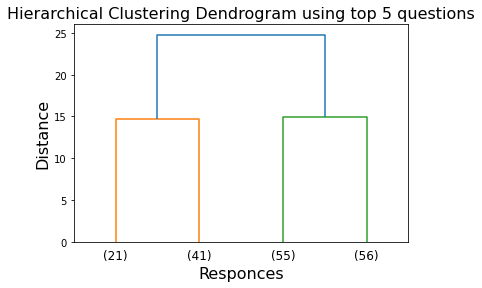

In [39]:
    model5 = AgglomerativeClustering(distance_threshold=None,n_clusters=4, compute_distances=True )
    model5 = model5.fit( dfs[top_questions])
#     fig = plt.figure(figsize = (5,5))
    plt.title('Hierarchical Clustering Dendrogram using top {0} questions'.format(len(top_questions)), fontsize= 16)
    # plot the top three levels of the dendrogram
    get_dendrogram(model5, truncate_mode='level', p=1)
    plt.xlabel("Responces", fontsize= 16 )
    plt.ylabel("Distance", fontsize= 16 )
    plt.xticks(fontsize= 12 )
    plt.show()

In [41]:
dfnew['Responce_ID'] = np.arange(0, len(dfnew)) 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


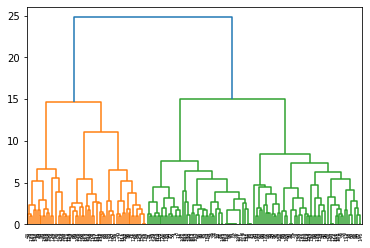

In [42]:
model5 = AgglomerativeClustering(distance_threshold=0,n_clusters=None)
model5 = model5.fit(dfnew[top_questions])
d = get_dendrogram(model5, truncate_mode='level', p=24)
clustT = pd.DataFrame(index =d['leaves'],data=d['leaves_color_list'], columns=['cluster'])

model5 = AgglomerativeClustering(distance_threshold=None,n_clusters=4)
model5 = model5.fit(dfnew[top_questions])
clust2 = pd.DataFrame(index =dfnew.index,data=model5.labels_, columns=['cluster'])
mCluster2 = pd.merge(dfnew,clust2, how='inner', left_index=True, right_index=True)

In [43]:
len(clustT)

173

In [44]:
encoder = OrdinalEncoder()
print(adjusted_rand_score(clust2.values.ravel(),encoder.fit_transform(np.array(clustT.sort_index()).reshape(-1, 1)).ravel()))

0.48767476375004587


In [45]:
c2 = encoder.fit_transform(np.array(clustT.sort_index()).reshape(-1, 1)).ravel()

In [46]:
print(adjusted_rand_score(clust2.values.ravel(), clust1.values.ravel()))

0.2314291344861134


In [47]:

list_of_df = []
number_drop_samples = int(len(dfnew)/10) 
keep_samples = len(dfnew) - number_drop_samples
np.random.seed(60)
for i in range(0,10):
    train = np.random.choice(dfnew.index, keep_samples, replace=False)
    currnet_subset =  dfnew.iloc[train]
    model6 = AgglomerativeClustering(distance_threshold=None,n_clusters=4, compute_distances= True)
    model6 = model6.fit(currnet_subset[top_questions])
    labels = [str(l) for l in model6.labels_]
    clustC = pd.DataFrame(index =currnet_subset.index, data=labels, columns=['cluster_fold{0}'.format(i)])
    mClusterN = pd.merge(currnet_subset,clustC, how='inner', left_index=True, right_index=True)
    temp = pd.merge(clust2,clustC, how='inner', left_index=True, right_index=True)
    t = temp.dropna()
    print(adjusted_rand_score(t.iloc[:,0], t.iloc[:,1]))
    list_of_df.append(mClusterN)


0.760862303972668
0.6598980579392218
0.6814301059732102
0.5521145908448284
0.5712044342219592
0.7428801635450628
0.6091267015456607
0.6607866943914805
0.6700764578955729
0.8026503155266946


In [48]:
newM = pd.merge(list_of_df[0], list_of_df[1], how="outer", on=list(dfnew.columns.values))

In [49]:
for z in range(2, len(list_of_df)):
    newM = pd.merge(newM, list_of_df[z], how="outer", on=list(dfnew.columns.values))

In [50]:
newM

,If I see that I perform health-related activities better than my peers I feel motivated,When I am stressed I am unlikely to respond to any reminders for health-related activities,I am keen to perform a simple activity for a longer time when I want to break my own record,I am keen to perform a simple activity for a longer time when I compete with others,When I am tired I am unlikely to respond to reminders for health-related activities,Responce_ID,cluster_fold0,cluster_fold1,cluster_fold2,cluster_fold3,cluster_fold4,cluster_fold5,cluster_fold6,cluster_fold7,cluster_fold8,cluster_fold9
0,4,4.0,4,3.0,3.0,140,2,3,1,2,1,1,1,2,3,2
1,3,4.0,2,2.0,4.0,21,0,NaN,3,3,0,0,0,3,0,0
2,1,1.0,1,1.0,1.0,170,3,NaN,NaN,0,3,3,2,0,2,3
3,3,3.0,5,3.0,3.0,33,1,3,NaN,NaN,1,1,NaN,1,1,1
4,3,5.0,5,3.0,4.0,120,2,3,2,2,2,2,0,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,4,4.0,4,4.0,3.0,161,NaN,3,2,2,2,1,1,2,3,NaN
169,1,4.0,3,2.0,4.0,65,NaN,1,0,NaN,0,0,0,0,0,0
170,4,2.0,2,4.0,4.0,99,NaN,0,1,1,1,1,1,1,NaN,1
171,1,2.0,5,1.0,2.0,72,NaN,2,0,0,1,3,2,1,1,3


In [51]:
top_questions

['If I see that I perform health-related activities better than my peers I feel motivated',
 'When I am stressed I am unlikely to respond to any reminders for health-related activities',
 'I am keen to perform a simple activity for a longer time when I want to break my own record',
 'I am keen to perform a simple activity for a longer time when I compete with others',
 'When I am tired  I am unlikely to respond to reminders for health-related activities']

In [52]:
q = top_questions[0]

In [53]:
mCluster2

,If I see that I perform health-related activities better than my peers I feel motivated,When I am stressed I am unlikely to respond to any reminders for health-related activities,I am keen to perform a simple activity for a longer time when I want to break my own record,I am keen to perform a simple activity for a longer time when I compete with others,When I am tired I am unlikely to respond to reminders for health-related activities,Responce_ID,cluster
0,3,2.0,4,3.0,2.0,0,1
1,3,4.0,4,3.0,5.0,1,2
2,4,4.0,4,4.0,4.0,2,2
3,4,4.0,4,3.0,5.0,3,2
4,4,5.0,5,5.0,3.0,4,2
...,...,...,...,...,...,...,...
168,2,3.0,1,2.0,4.0,168,3
169,4,5.0,5,1.0,4.0,169,2
170,1,1.0,1,1.0,1.0,170,3
171,5,5.0,3,2.0,5.0,171,0


In [54]:
total0 = mCluster2.loc[mCluster2['cluster'] == 0].count()[0]
total1 = mCluster2.loc[mCluster2['cluster'] == 1].count()[0]
total2 = mCluster2.loc[mCluster2['cluster'] == 2].count()[0]
total3 = mCluster2.loc[mCluster2['cluster'] == 3].count()[0]
total4 = mCluster2.loc[mCluster2['cluster'] == 4].count()[0]

In [55]:
total0, total1, total2, total3, total4

(41, 56, 55, 21, 0)

invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars


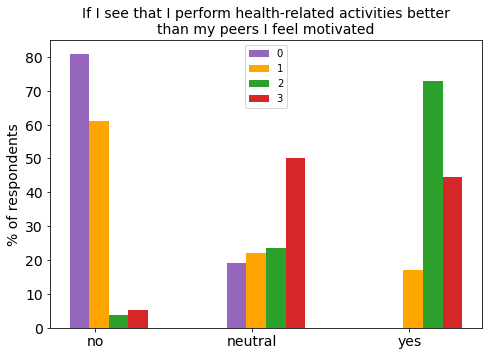

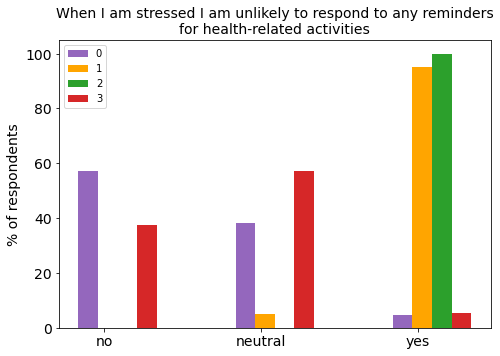

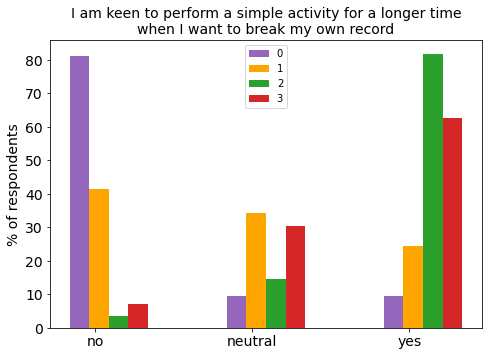

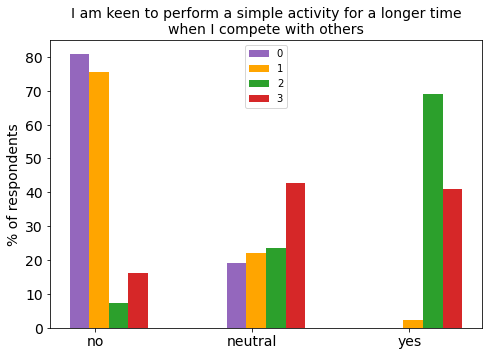

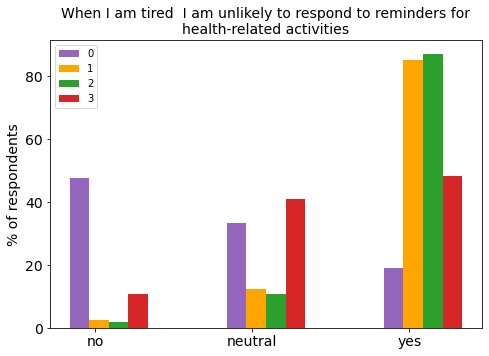

In [56]:
for q in top_questions:
    no0 = mCluster2.loc[(mCluster2[q]==1 )& (mCluster2['cluster'] == 0)].count()[0]
    no01 = mCluster2.loc[(mCluster2[q]==2 )& (mCluster2['cluster'] == 0)].count()[0]
    ne0 = mCluster2.loc[(mCluster2[q]==3 )& (mCluster2['cluster'] == 0)].count()[0]
    ye0 = mCluster2.loc[(mCluster2[q]==4 )& (mCluster2['cluster'] == 0)].count()[0]
    ye01 = mCluster2.loc[(mCluster2[q]==5 )& (mCluster2['cluster'] == 0)].count()[0]

    no1 = mCluster2.loc[(mCluster2[q]==1 )& (mCluster2['cluster'] == 1)].count()[0]
    no11 = mCluster2.loc[(mCluster2[q]==2 )& (mCluster2['cluster'] == 1)].count()[0]
    ne1 = mCluster2.loc[(mCluster2[q]==3 )& (mCluster2['cluster'] == 1)].count()[0]
    ye1 = mCluster2.loc[(mCluster2[q]==4 )& (mCluster2['cluster'] == 1)].count()[0]
    ye11 = mCluster2.loc[(mCluster2[q]==5 )& (mCluster2['cluster'] == 1)].count()[0]


    no2 = mCluster2.loc[(mCluster2[q]==1 )& (mCluster2['cluster'] == 2)].count()[0]
    no21 = mCluster2.loc[(mCluster2[q]==2 )& (mCluster2['cluster'] == 2)].count()[0]
    ne2 = mCluster2.loc[(mCluster2[q]==3 )& (mCluster2['cluster'] == 2)].count()[0]
    ye2 = mCluster2.loc[(mCluster2[q]==4 )& (mCluster2['cluster'] == 2)].count()[0]
    ye21 = mCluster2.loc[(mCluster2[q]==5 )& (mCluster2['cluster'] == 2)].count()[0]
    
    no3 = mCluster2.loc[(mCluster2[q]==1 )& (mCluster2['cluster'] == 3)].count()[0]
    no31 = mCluster2.loc[(mCluster2[q]==2 )& (mCluster2['cluster'] == 3)].count()[0]
    ne3 = mCluster2.loc[(mCluster2[q]==3 )& (mCluster2['cluster'] == 3)].count()[0]
    ye3 = mCluster2.loc[(mCluster2[q]==4 )& (mCluster2['cluster'] == 3)].count()[0]
    ye31 = mCluster2.loc[(mCluster2[q]==5 )& (mCluster2['cluster'] == 3)].count()[0]
    
    no4 = mCluster2.loc[(mCluster2[q]==1 )& (mCluster2['cluster'] == 4)].count()[0]
    no41 = mCluster2.loc[(mCluster2[q]==2 )& (mCluster2['cluster'] == 4)].count()[0]
    ne4 = mCluster2.loc[(mCluster2[q]==3 )& (mCluster2['cluster'] == 4)].count()[0]
    ye4 = mCluster2.loc[(mCluster2[q]==4 )& (mCluster2['cluster'] == 4)].count()[0]
    ye41 = mCluster2.loc[(mCluster2[q]==5 )& (mCluster2['cluster'] == 4)].count()[0]

    data = [
            [(no3+ no31)/total3 * 100, ne3/total3* 100, (ye3+ye31)/total3 * 100],
            [(no0+ no01)/total0 * 100, ne0/total0  * 100, (ye0+ye01)/total0  * 100],
              [(no2+ no21)/total2 * 100, ne2/total2 * 100, (ye2+ye21)/total2 * 100],
    [(no1+ no11)/total1 * 100,  ne1/total1  * 100, (ye1+ye11)/total1  * 100],

     [(no4+ no41)/total4 * 100, ne4/total4* 100, (ye4+ye41)/total4 * 100]
           ]
    
    X = np.array([1,3,5])
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ticks = [1.2,3.2,5.2]
    ax.bar(X + 0.00, data[0], color = 'tab:purple', width = 0.25)
    ax.bar(X + 0.25, data[1], color = 'orange', width = 0.25)
    ax.bar(X + 0.50, data[2], color = 'tab:green', width = 0.25)
    ax.bar(X + 0.75, data[3], color = 'tab:red', width = 0.25)
#     ax.bar(X + 1.0, data[4], color = 'tab:brown', width = 0.25)
    ax.set_title('\n'.join(wrap(q,60)), fontsize=14)
    ax.legend(labels=['0', '1', '2', '3', '4'])
    ax.set_xticks(ticks, minor=False)
    ax.set_xticklabels(  ['no', 'neutral', 'yes'], fontsize=14)
#     ax.set_ylim(0,90)
    # ax.set_xlabel("Responce", fontsize=16)
    plt.yticks(fontsize=14)
    ax.set_ylabel("% of respondents", fontsize=14)

In [62]:
X_train,X_test,Y_train,Y_test = train_test_split(dfnew[top_questions], clust2, test_size=0.2, random_state=0)

In [63]:
rforest = RandomForestClassifier( max_depth=None, min_samples_split=2, random_state=0)
rforest.fit(X_train, Y_train)
# print_accuracy(rforest.predict)
shap.initjs()
# explain all the predictions in the test set
explainer = shap.KernelExplainer(rforest.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Using 138 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/35 [00:00<?, ?it/s]

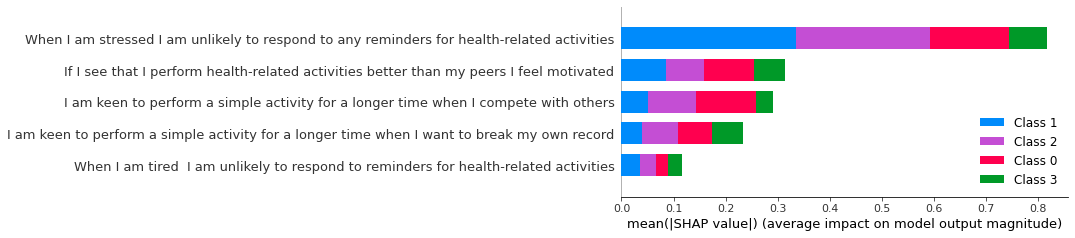

In [64]:
shap.summary_plot(shap_values, dfnew[top_questions])

In [65]:
y = clust2.values.ravel()

In [66]:
respondent = clust2.index.values

In [67]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
#         if y[i] == 0:
#             color = 'darkorange'
#         elif y[i] == 1:
#             color = 'red'
#         else:
#             color = 'green'
        plt.text(X[i, 0], X[i, 1], str(respondent[i]),
                 color=plt.cm.tab10(int(y[i] +1)),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
        
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [68]:
X_embedded = TSNE(n_components=2, perplexity=10).fit_transform(dfnew[top_questions])

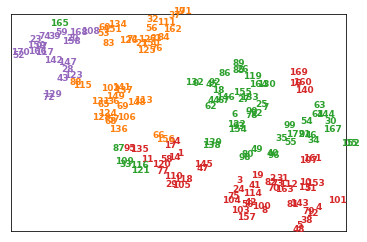

In [69]:
 plot_embedding(X_embedded, title=None)

In [70]:
mCluster2.groupby("cluster").agg(lambda x:x.value_counts().index[0])

,If I see that I perform health-related activities better than my peers I feel motivated,When I am stressed I am unlikely to respond to any reminders for health-related activities,I am keen to perform a simple activity for a longer time when I want to break my own record,I am keen to perform a simple activity for a longer time when I compete with others,When I am tired I am unlikely to respond to reminders for health-related activities,Responce_ID
cluster,,,,,,
0,2,4.0,3,2.0,4.0,125
1,3,3.0,4,3.0,3.0,0
2,4,4.0,4,4.0,4.0,1
3,1,2.0,1,1.0,2.0,97


In [71]:
mCluster2.groupby("cluster").mean()

,If I see that I perform health-related activities better than my peers I feel motivated,When I am stressed I am unlikely to respond to any reminders for health-related activities,I am keen to perform a simple activity for a longer time when I want to break my own record,I am keen to perform a simple activity for a longer time when I compete with others,When I am tired I am unlikely to respond to reminders for health-related activities,Responce_ID
cluster,,,,,,
0,2.365854,4.390244,2.658537,1.926829,4.219512,98.414634
1,3.553571,2.589286,3.714286,3.321429,3.428571,84.089286
2,3.781818,4.345455,4.127273,3.781818,4.145455,73.454545
3,1.761905,2.380952,1.809524,1.619048,2.619048,99.714286


## Personality <a class="anchor" id="pers"></a>

In [118]:
personality = pd.read_csv("CAPABLE_Questionair_Behaviourl_Models.csv")

In [119]:
personality = personality.drop(columns=['Unnamed: 0', 'Timestamp',
       'Do you agree that your answers will be used for research purposes? ',
       'You identify yourself as:', 'Age', 'Nationality',
       'Have you been diagnosed with cancer? ']) 

personality = personality.drop(columns=['What motivates you the most to maintain healthy habits?',
       'When do you feel like you can/want to perform an activity that is beneficial to your health? ',
       'How do you remind yourself to perform activities aligned with your goals? ',
                       'How many daily reminders for health-related activities would you be willing to receive? ', 
                       'Select a simple activity that you would be happy to perform to improve your wellbeing.  Consider this activity when answering later questions in this survey. '])

In [120]:
# keep = list(top_questions) +personality_qestions

In [121]:
# personality = personality[keep]

In [122]:
personality

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort),My family members motivate me to look after my health,When I am in a good mood I am motivated to perform activities that benefit my health,When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule,"Before the visit to my doctor, I tend to be more compliant with my health recommendations","If I see that my peers perform health-related activities better than me, I get discouraged",If I see that I perform health-related activities better than my peers I feel motivated,I am keen to perform a simple activity for a longer time when I compete with others,I am keen to perform a simple activity for a longer time when I want to break my own record,...,I see myself as someone who is reserved,I see myself as someone who is generally trusting,I see myself as someone who tends to be lazy,"I see myself as someone who is relaxed, handles stress well",I see myself as someone who has few artistic interests,"I see myself as someone who is outgoing, sociable",I see myself as someone who tends to find fault with others,I see myself as someone who does a thorough job,I see myself as someone who gets nervous easily,I see myself as someone who has an active imagination
0,4,4.0,4.0,5.0,3.0,2,3,3,3.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,5.0,2.0,4.0,2.0,2,2,3,3.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,5.0,3.0,5.0,5.0,3,3,4,4.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,5.0,5.0,4.0,2.0,3,2,4,3.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5.0,4.0,5.0,4.0,4,3,4,5.0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,3,5.0,4.0,5.0,4.0,3,1,2,2.0,1,...,4.0,3.0,3.0,2.0,3.0,5.0,3.0,5.0,4.0,3.0
169,3,3.0,5.0,4.0,5.0,1,1,4,1.0,5,...,5.0,3.0,4.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0
170,5,1.0,3.0,5.0,3.0,1,1,1,1.0,1,...,5.0,1.0,1.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0
171,4,5.0,1.0,3.0,4.0,1,4,5,2.0,3,...,3.0,4.0,5.0,2.0,3.0,4.0,4.0,4.0,3.0,4.0


In [123]:
personalityAndClust = pd.merge(personality,clust2, how='inner', left_index=True, right_index=True)

In [124]:
personalityAndClust =personalityAndClust.dropna()

In [125]:
personalityAndClust

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort),My family members motivate me to look after my health,When I am in a good mood I am motivated to perform activities that benefit my health,When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule,"Before the visit to my doctor, I tend to be more compliant with my health recommendations","If I see that my peers perform health-related activities better than me, I get discouraged",If I see that I perform health-related activities better than my peers I feel motivated,I am keen to perform a simple activity for a longer time when I compete with others,I am keen to perform a simple activity for a longer time when I want to break my own record,...,I see myself as someone who is generally trusting,I see myself as someone who tends to be lazy,"I see myself as someone who is relaxed, handles stress well",I see myself as someone who has few artistic interests,"I see myself as someone who is outgoing, sociable",I see myself as someone who tends to find fault with others,I see myself as someone who does a thorough job,I see myself as someone who gets nervous easily,I see myself as someone who has an active imagination,cluster
67,4,5.0,4.0,5.0,3.0,1,3,3,3.0,4,...,4.0,4.0,2.0,2.0,3.0,1.0,3.0,3.0,5.0,1
70,4,2.0,4.0,4.0,2.0,4,2,4,4.0,4,...,4.0,2.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,2
71,3,4.0,3.0,4.0,4.0,4,4,3,2.0,2,...,2.0,4.0,3.0,2.0,2.0,4.0,3.0,4.0,5.0,0
72,5,5.0,3.0,3.0,3.0,3,1,1,1.0,5,...,5.0,1.0,5.0,1.0,4.0,1.0,5.0,3.0,5.0,3
73,4,3.0,5.0,4.0,2.0,4,2,4,4.0,4,...,4.0,4.0,3.0,2.0,3.0,3.0,4.0,3.0,4.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,3,5.0,4.0,5.0,4.0,3,1,2,2.0,1,...,3.0,3.0,2.0,3.0,5.0,3.0,5.0,4.0,3.0,3
169,3,3.0,5.0,4.0,5.0,1,1,4,1.0,5,...,3.0,4.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0,2
170,5,1.0,3.0,5.0,3.0,1,1,1,1.0,1,...,1.0,1.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0,3
171,4,5.0,1.0,3.0,4.0,1,4,5,2.0,3,...,4.0,5.0,2.0,3.0,4.0,4.0,4.0,3.0,4.0,0


### Personality trait computation

Scoring the BFI-10 scales:

Extraversion: 1R, 6; Agreeableness: 2, 7R; Conscientiousness: 3R, 8; Neuroticism: 4R, 9;

Openness: 5R; 10 (R = item is reversed-scored).


In [126]:
def reverse(num):
    return abs(num -6)

In [127]:
personalityAndClust.columns

Index(['I feel motivated to perform activities that I perceive having benefit to my health and well-being',
       'When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort) ',
       'My family members motivate me to look after my health',
       'When I am in a good mood I am  motivated to perform activities that benefit my health',
       'When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule',
       'Before the visit to my doctor, I tend to be more compliant with my health recommendations',
       'If I see that my peers perform health-related activities better than me,  I get discouraged ',
       'If I see that I perform health-related activities better than my peers I feel motivated',
       'I am keen to perform a simple activity for a longer time when I compete with others',
       'I am keen to perform a simple activity for a longer time when I want to brea

In [128]:
def compute_personality_trait(score, rev_score):
    return score + reverse(rev_score)

In [129]:
personalityAndClust['Extraversion'] =personalityAndClust.apply(lambda row : compute_personality_trait(row['I see myself as someone who is outgoing, sociable'],
                     row['I see myself as someone who is reserved']), axis = 1)
personalityAndClust['Agreeableness'] =personalityAndClust.apply(lambda row : compute_personality_trait(row['I see myself as someone who is generally trusting'],
                     row['I see myself as someone who tends to find fault with others']), axis = 1)
personalityAndClust['Conscientiousness'] =personalityAndClust.apply(lambda row : compute_personality_trait(row['I see myself as someone who does a thorough job'],
                     row['I see myself as someone who tends to be lazy']), axis = 1)
personalityAndClust['Neuroticism'] =personalityAndClust.apply(lambda row : compute_personality_trait(row['I see myself as someone who gets nervous easily'],
                     row['I see myself as someone who is relaxed, handles stress well']), axis = 1)
personalityAndClust['Openness'] =personalityAndClust.apply(lambda row : compute_personality_trait(row['I see myself as someone who has an active imagination'],
                     row['I see myself as someone who has few artistic interests']), axis = 1)


In [134]:
personalityAllButClut = personalityAndClust.drop(columns=['cluster'])

In [141]:
responces = personalityAllButClut.iloc[:,:-15]

In [142]:
responces

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort),My family members motivate me to look after my health,When I am in a good mood I am motivated to perform activities that benefit my health,When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule,"Before the visit to my doctor, I tend to be more compliant with my health recommendations","If I see that my peers perform health-related activities better than me, I get discouraged",If I see that I perform health-related activities better than my peers I feel motivated,I am keen to perform a simple activity for a longer time when I compete with others,I am keen to perform a simple activity for a longer time when I want to break my own record,...,I am more likely to perform suggested health-related activity when I am not focused on any other tasks,When I am stressed I am unlikely to respond to any reminders for health-related activities,When I am stressed I find it helpful to perform a relaxing/calming down activity,When I am tired I am unlikely to respond to reminders for health-related activities,I am likely to respond to reminders for health-related activities when I am bored,I am more likely to respond to reminders for health-related activities when I am relaxed than when I am stressed,I am likely to respond to reminders for health-related activities when I am relaxed,"I am more likely to respond to the reminders for health-related activities when I am at home than elsewhere (park, shop, etc.)",I would respond to reminders for health-related activities while I am walking.,I would respond to reminders for health-related activities while I am sitting or standing.
67,4,5.0,4.0,5.0,3.0,1,3,3,3.0,4,...,5.0,2.0,4.0,4.0,5.0,2.0,4.0,5.0,4.0,4.0
70,4,2.0,4.0,4.0,2.0,4,2,4,4.0,4,...,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0
71,3,4.0,3.0,4.0,4.0,4,4,3,2.0,2,...,3.0,4.0,3.0,5.0,3.0,4.0,3.0,5.0,1.0,3.0
72,5,5.0,3.0,3.0,3.0,3,1,1,1.0,5,...,3.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,1.0,3.0
73,4,3.0,5.0,4.0,2.0,4,2,4,4.0,4,...,2.0,4.0,4.0,4.0,2.0,4.0,4.0,5.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,3,5.0,4.0,5.0,4.0,3,1,2,2.0,1,...,5.0,3.0,5.0,4.0,3.0,5.0,5.0,1.0,5.0,5.0
169,3,3.0,5.0,4.0,5.0,1,1,4,1.0,5,...,3.0,5.0,5.0,4.0,3.0,4.0,5.0,5.0,5.0,5.0
170,5,1.0,3.0,5.0,3.0,1,1,1,1.0,1,...,4.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
171,4,5.0,1.0,3.0,4.0,1,4,5,2.0,3,...,4.0,5.0,1.0,5.0,3.0,4.0,4.0,4.0,3.0,4.0


### Personality regresion

In [204]:
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [205]:
X_train,X_test,Y_train,Y_test = train_test_split(responces.values, personalityAndClust[['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']].values, test_size=0.25, random_state=6)

In [206]:
reg = MultiTaskLassoCV(cv=5, random_state=0).fit(X_train,Y_train)

In [207]:
r2_score(Y_test, reg.predict(X_test))

-0.049339803271973494

In [208]:
mean_absolute_error(Y_test, reg.predict(X_test))

1.598474178403756

In [182]:
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

1.6805555555555554
When I am stressed I am unlikely to respond to any reminders for health-related activities    0.564715
dtype: float64


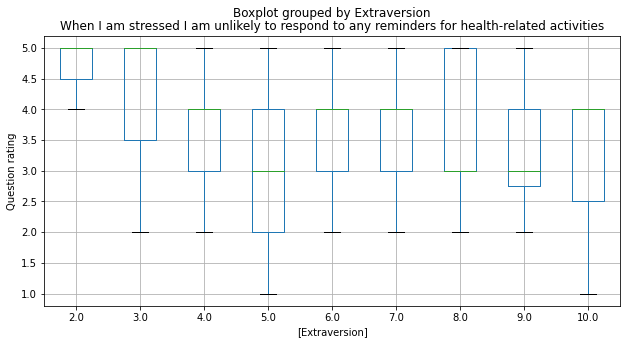

1.1815025252525253
I am likely to respond to reminders for health-related activities when I am relaxed    0.416638
dtype: float64


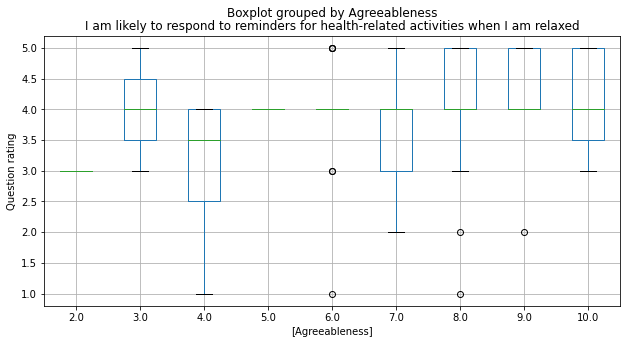

1.2750220458553791
When I am tired  I am unlikely to respond to reminders for health-related activities    0.651835
dtype: float64


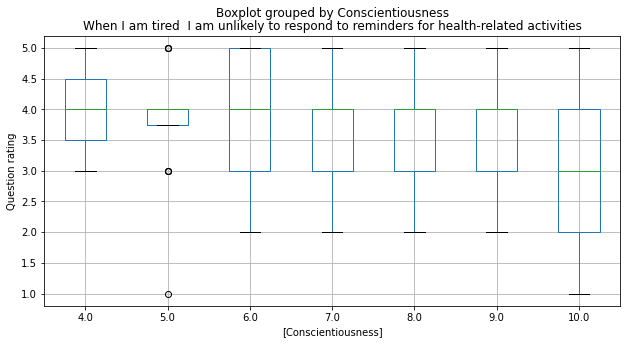

1.7577747584541061
When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule    0.954348
dtype: float64


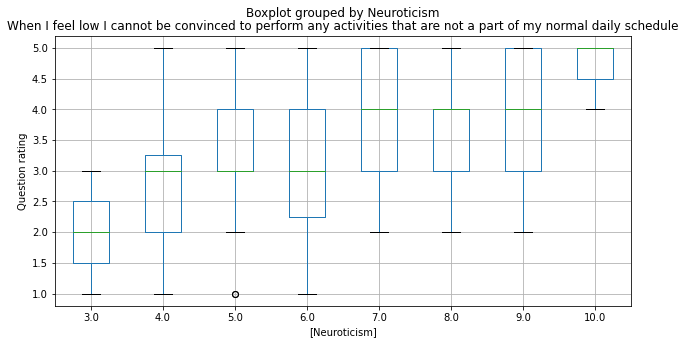

1.47135101010101
I am keen to perform a simple health-related activity for longer than the recommended minimum time, when I enjoy it     0.561394
dtype: float64


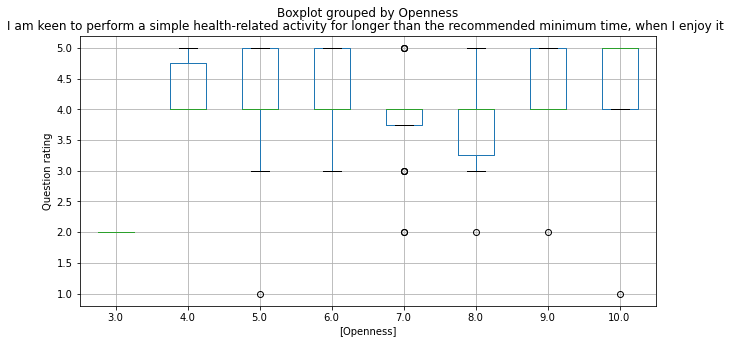

In [248]:
for p in ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']:
    X_train,X_test,Y_train,Y_test = train_test_split(responces, personalityAndClust[p], test_size=0.25, random_state=66)
    regressor = ExtraTreeRegressor(random_state=6, min_samples_leaf=15)
    regressor.fit(X_train, Y_train )
    print(mean_absolute_error(Y_test, regressor.predict(X_test)))
    importances = regressor.feature_importances_
    r_importances = pd.Series(importances, index=responces.columns)
    sorted_idx = r_importances.argsort()
    top1 = r_importances[sorted_idx][-1:]
    print(top1)
    fig = plt.figure(figsize = (10,5))
    ax = fig.gca()
    personalityAllButClut[[top1.index[0],p]].boxplot(by=p, ax=ax)
    plt.ylabel('Question rating')
    plt.show()

In [227]:
responces[top1.index[0]].values

array([4., 4., 4., 4., 4., 4., 4., 3., 2., 4., 5., 5., 3., 5., 4., 4., 5.,
       4., 4., 4., 5., 5., 4., 5., 3., 3., 4., 4., 4., 4., 5., 5., 5., 5.,
       4., 4., 2., 3., 4., 4., 3., 4., 4., 4., 5., 4., 5., 3., 3., 5., 4.,
       4., 5., 5., 4., 4., 4., 3., 4., 4., 4., 4., 5., 4., 5., 5., 3., 4.,
       4., 4., 5., 5., 5., 4., 2., 5., 4., 5., 4., 5., 1., 4., 4., 4., 5.,
       4., 4., 4., 2., 5., 5., 4., 1., 2., 5.])

In [233]:
personalityAllButClut[[top1.index[0],p]]

,"I am keen to perform a simple health-related activity for longer than the recommended minimum time, when I enjoy it",Openness
67,4.0,9.0
70,4.0,6.0
71,4.0,9.0
72,4.0,10.0
73,4.0,8.0
...,...,...
168,5.0,6.0
169,4.0,5.0
170,1.0,5.0
171,2.0,7.0


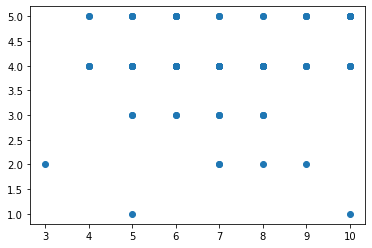

In [230]:
plt.scatter(personalityAndClust[p].values, responces[top1.index[0]].values)
plt.show()

<AxesSubplot:title={'center':'I am keen to perform a simple health-related activity for longer than the recommended minimum time, when I enjoy it '}, xlabel='[Openness]'>

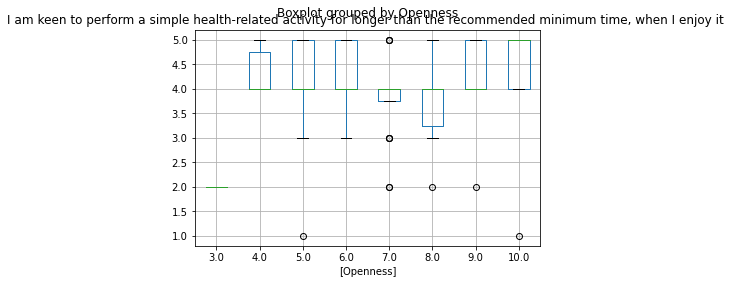

In [238]:
fig = plt.figure()
ax = fig.gca()
personalityAllButClut[[top1.index[0],p]].boxplot(by=p, ax=ax)

In [195]:
personalityAllButClut.groupby("Extraversion").mean().iloc[:,:-14]

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort),My family members motivate me to look after my health,When I am in a good mood I am motivated to perform activities that benefit my health,When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule,"Before the visit to my doctor, I tend to be more compliant with my health recommendations","If I see that my peers perform health-related activities better than me, I get discouraged",If I see that I perform health-related activities better than my peers I feel motivated,I am keen to perform a simple activity for a longer time when I compete with others,I am keen to perform a simple activity for a longer time when I want to break my own record,...,I am more likely to perform suggested health-related activity when I am not focused on any other tasks,When I am stressed I am unlikely to respond to any reminders for health-related activities,When I am stressed I find it helpful to perform a relaxing/calming down activity,When I am tired I am unlikely to respond to reminders for health-related activities,I am likely to respond to reminders for health-related activities when I am bored,I am more likely to respond to reminders for health-related activities when I am relaxed than when I am stressed,I am likely to respond to reminders for health-related activities when I am relaxed,"I am more likely to respond to the reminders for health-related activities when I am at home than elsewhere (park, shop, etc.)",I would respond to reminders for health-related activities while I am walking.,I would respond to reminders for health-related activities while I am sitting or standing.
Extraversion,,,,,,,,,,,,,,,,,,,,,
2.0,3.666667,3.000000,2.333333,3.000000,3.666667,2.666667,2.333333,3.000000,2.333333,2.666667,...,5.000000,4.666667,3.666667,4.666667,2.333333,4.000000,3.666667,4.333333,2.666667,3.333333
3.0,4.000000,4.200000,3.200000,4.500000,3.900000,3.200000,1.600000,2.800000,2.600000,3.500000,...,4.500000,4.200000,2.900000,3.700000,3.400000,4.500000,4.200000,4.300000,3.100000,3.800000
4.0,4.111111,4.166667,3.333333,4.333333,3.055556,2.777778,2.222222,3.444444,2.777778,3.277778,...,4.000000,3.500000,3.666667,3.944444,3.611111,4.111111,4.222222,4.222222,2.611111,3.444444
5.0,3.937500,3.750000,3.750000,4.125000,3.187500,2.500000,2.312500,2.687500,2.500000,3.062500,...,3.750000,3.062500,3.000000,3.437500,2.875000,3.500000,3.375000,3.250000,3.250000,3.250000
6.0,3.928571,4.214286,3.357143,4.285714,3.214286,2.500000,2.357143,2.785714,3.071429,3.785714,...,4.142857,3.571429,3.428571,3.714286,3.285714,4.071429,3.857143,3.500000,3.071429,3.142857
7.0,3.785714,4.214286,3.142857,3.928571,3.214286,2.714286,1.785714,3.000000,2.857143,3.071429,...,3.500000,3.642857,3.642857,3.571429,3.071429,3.928571,4.000000,3.285714,2.785714,3.285714
8.0,4.000000,4.111111,3.555556,4.444444,3.777778,3.000000,2.333333,3.333333,2.777778,3.555556,...,4.000000,3.555556,3.777778,3.333333,2.777778,4.000000,4.111111,3.444444,3.111111,3.333333
9.0,4.375000,4.250000,4.125000,4.500000,3.000000,2.750000,2.375000,3.000000,3.125000,3.125000,...,4.750000,3.250000,4.250000,4.000000,3.250000,3.625000,3.500000,4.000000,3.000000,3.250000
10.0,4.666667,4.666667,3.666667,4.666667,3.000000,3.000000,2.333333,3.666667,3.666667,4.333333,...,4.000000,3.000000,3.333333,2.666667,3.000000,3.000000,3.333333,3.333333,2.666667,2.666667


### Personality and responce clusters

In [130]:
personalityAndClustOnly = personalityAndClust[['cluster', 'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']]

In [131]:
personalityAndClustOnly.groupby("cluster").mean()

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
cluster,,,,,
0,4.913043,6.739130,6.869565,6.130435,6.826087
1,5.967742,6.935484,6.774194,5.774194,7.096774
2,5.964286,7.785714,7.214286,6.142857,7.500000
3,6.076923,7.153846,7.461538,5.538462,6.615385


In [132]:
personalityAndClustOnly.groupby("cluster").agg(lambda x:x.value_counts().index[0]) # mode

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
cluster,,,,,
0,4.0,7.0,6.0,4.0,6.0
1,5.0,7.0,5.0,4.0,7.0
2,7.0,8.0,6.0,5.0,7.0
3,5.0,7.0,8.0,5.0,10.0


In [86]:
df_preferred= pd.read_csv("CAPABLE_Questionair_Behaviourl_Models.csv")

In [87]:
df_preferred = df_preferred[['Select a simple activity that you would be happy to perform to improve your wellbeing.  Consider this activity when answering later questions in this survey. ',
                            'How many daily reminders for health-related activities would you be willing to receive? ']]

In [88]:
df_preferred_and_personality  = pd.merge(df_preferred,personalityAndClust[['cluster', 'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']], how='inner', left_index=True, right_index=True)

In [89]:
q = "How many daily reminders for health-related activities would you be willing to receive? "

In [90]:
df_preferred_and_personality[[q]] = df_preferred_and_personality[[q]].applymap(lambda x: x.replace("Non più di", "No more than"))

In [91]:
df_preferred_and_personality.groupby(q).agg(lambda x:x.value_counts().index[0]) 

,Select a simple activity that you would be happy to perform to improve your wellbeing. Consider this activity when answering later questions in this survey.,cluster,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
How many daily reminders for health-related activities would you be willing to receive?,,,,,,,
0,a walk in nature (30 minutes),1,6.0,7.0,6.0,4.0,5.0
I would tolerate more than 4 reminders,a walk in nature (30 minutes),1,4.0,7.0,7.0,5.0,7.0
No more than 1,a walk in nature (30 minutes),2,7.0,7.0,6.0,7.0,8.0
No more than 2,a walk in nature (30 minutes),0,5.0,8.0,6.0,4.0,6.0
No more than 3,a walk in nature (30 minutes),1,4.0,7.0,8.0,6.0,7.0
No more than 4,a walk in nature (30 minutes),1,6.0,3.0,5.0,7.0,4.0


In [92]:
X_train,X_test,Y_train,Y_test = train_test_split(df_preferred_and_personality[['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']], df_preferred_and_personality[['cluster']], test_size=0.3, random_state=0)

In [93]:
rforest2 = RandomForestClassifier(random_state=0, class_weight="balanced")
rforest2.fit(X_train, Y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(class_weight='balanced', random_state=0)

In [94]:
np.unique(Y_test)

array([0, 1, 2, 3], dtype=int64)

In [95]:


print(classification_report(Y_test, rforest2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.40      0.25      0.31         8
           1       0.33      0.33      0.33         9
           2       0.36      0.56      0.43         9
           3       0.00      0.00      0.00         5

    accuracy                           0.32        31
   macro avg       0.27      0.28      0.27        31
weighted avg       0.30      0.32      0.30        31



In [96]:
X_train,X_test,Y_train,Y_test = train_test_split(df_preferred_and_personality[['Agreeableness']], df_preferred_and_personality[['cluster']], test_size=0.3, random_state=0)

In [97]:
rforest3 = RandomForestClassifier( random_state=0, class_weight="balanced")
rforest3.fit(X_train, Y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(class_weight='balanced', random_state=0)

In [98]:
print(classification_report(Y_test, rforest3.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.20      0.11      0.14         9
           2       0.31      0.56      0.40         9
           3       0.00      0.00      0.00         5

    accuracy                           0.19        31
   macro avg       0.13      0.17      0.14        31
weighted avg       0.15      0.19      0.16        31



## Statistical testing
<a class="anchor" id="stats"></a>

### Are the clusters significantly different in their responces (top 5 question)?

In [99]:
responces = mCluster2.drop(columns='Responce_ID')

In [100]:
zero = responces.loc[responces['cluster'] == 0]

In [101]:
one = responces.loc[responces['cluster'] == 1]

In [102]:
two = responces.loc[responces['cluster'] == 2]

three = responces.loc[responces['cluster'] == 3]
four = responces.loc[responces['cluster'] == 4]

In [103]:
stats.ttest_ind( zero[top_questions].values,one[top_questions].values, equal_var=False,  permutations=10000)

Ttest_indResult(statistic=array([-5.16104074, 13.42982605, -5.2490708 , -7.72007597,  4.70729597]), pvalue=array([0., 0., 0., 0., 0.]))

In [104]:
top_questions[1]

'When I am stressed I am unlikely to respond to any reminders for health-related activities'

In [105]:
stats.ttest_ind(one[top_questions].values, two[top_questions].values, equal_var=False, permutations=10000)

Ttest_indResult(statistic=array([ -1.53513848, -14.95891202,  -2.58193909,  -2.64764012,
        -4.57295162]), pvalue=array([0.1158, 0.    , 0.016 , 0.0106, 0.    ]))

In [106]:
stats.ttest_ind(zero[top_questions].values, two[top_questions].values, equal_var=False, permutations=10000)

Ttest_indResult(statistic=array([ -6.55935614,   0.39940869,  -7.55057889, -10.66317392,
         0.47389313]), pvalue=array([0.    , 0.7057, 0.    , 0.    , 0.65  ]))

In [107]:
ABC_anova = stats.f_oneway( zero[top_questions].values, one[top_questions].values,two[top_questions].values, three[top_questions].values)
print(ABC_anova)

F_onewayResult(statistic=array([ 38.20010803, 121.73522237,  42.4684266 ,  53.9782722 ,
        24.73244367]), pvalue=array([6.72124286e-19, 5.02860271e-42, 1.65901288e-20, 1.59741437e-24,
       2.56212122e-13]))


To output multiple subplots, the figure containing the passed axes is being cleared


array([[<AxesSubplot:title={'center':'I am keen to perform a simple activity for a longer time when I compete with others'}, xlabel='[cluster]'>,
        <AxesSubplot:title={'center':'I am keen to perform a simple activity for a longer time when I want to break my own record'}, xlabel='[cluster]'>],
       [<AxesSubplot:title={'center':'If I see that I perform health-related activities better than my peers I feel motivated'}, xlabel='[cluster]'>,
        <AxesSubplot:title={'center':'When I am stressed I am unlikely to respond to any reminders for health-related activities'}, xlabel='[cluster]'>],
       [<AxesSubplot:title={'center':'When I am tired  I am unlikely to respond to reminders for health-related activities'}, xlabel='[cluster]'>,
        <AxesSubplot:>]], dtype=object)

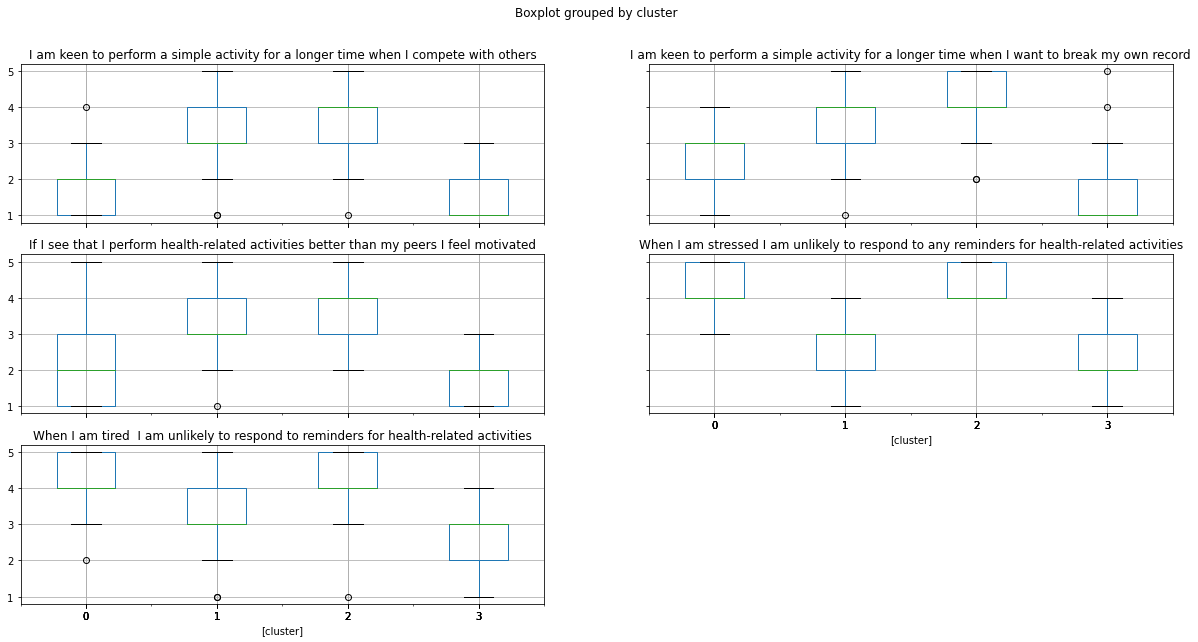

In [108]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
responces.boxplot(by='cluster', ax=ax)

### Are the clusters significantly different in their personality types ?

In [109]:
personality = personalityAndClust[['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness', 'cluster']]

In [110]:
p = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']

In [111]:
zero = personality.loc[personality['cluster'] == 0]
one = personality.loc[personality['cluster'] == 1]
two = personality.loc[personality['cluster'] == 2]
three = personality.loc[personality['cluster'] == 3]
# four = personality.loc[personality['cluster'] == 4]


In [112]:
stats.ttest_ind( zero[p].values,one[p].values, equal_var=False,  permutations=10000)

Ttest_indResult(statistic=array([-1.40863479, -0.45168192,  0.42504796,  0.75934221, -0.84435213]), pvalue=array([0.1712, 0.6522, 0.671 , 0.4795, 0.4014]))

In [113]:
stats.ttest_ind( zero[p].values,two[p].values, equal_var=False,  permutations=10000)

Ttest_indResult(statistic=array([-1.56628254, -2.10384332, -0.38886713, -0.09427903, -1.41028904]), pvalue=array([0.123 , 0.0383, 0.7333, 0.937 , 0.1645]))

In [114]:
stats.ttest_ind( one[p].values,two[p].values, equal_var=False,  permutations=10000)

Ttest_indResult(statistic=array([-0.18227521, -1.60475067, -0.90125735, -1.01017371, -0.700623  ]), pvalue=array([0.8312, 0.1121, 0.3882, 0.3146, 0.4859]))

In [115]:
ABC_anova = stats.f_oneway( zero[p].values, one[p].values,two[p].values, three[p].values)

In [116]:
ABC_anova

F_onewayResult(statistic=array([1.13011143, 1.57715479, 0.48652657, 0.61904393, 0.97647748]), pvalue=array([0.34081439, 0.19985843, 0.69243101, 0.60432954, 0.40716699]))

To output multiple subplots, the figure containing the passed axes is being cleared


array([[<AxesSubplot:title={'center':'Agreeableness'}, xlabel='[cluster]'>,
        <AxesSubplot:title={'center':'Conscientiousness'}, xlabel='[cluster]'>],
       [<AxesSubplot:title={'center':'Extraversion'}, xlabel='[cluster]'>,
        <AxesSubplot:title={'center':'Neuroticism'}, xlabel='[cluster]'>],
       [<AxesSubplot:title={'center':'Openness'}, xlabel='[cluster]'>,
        <AxesSubplot:>]], dtype=object)

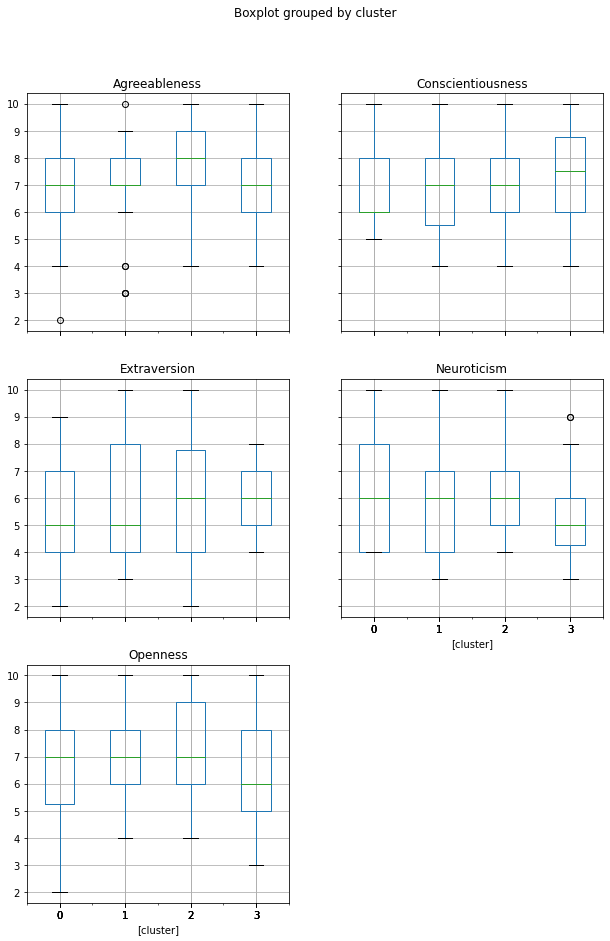

In [117]:
fig = plt.figure(figsize = (10,15))
ax = fig.gca()
personality.boxplot(by='cluster', ax=ax)